In [38]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Serif"
import pyipmeta as ipm
import requests
import wget
import shutil
import gzip
import json

from sklearn.linear_model import LinearRegression
import numpy as np

import geoplot.crs as gcrs
import geoplot
import os
from datetime import datetime
import socket 
import sys
import netaddr
from matplotlib.ticker import StrMethodFormatter, NullFormatter

In [4]:


import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import json
from dask.distributed import Client, LocalCluster


In [6]:
cluster = LocalCluster(n_workers=16, threads_per_worker=1, dashboard_address=':37940')  # Launches a scheduler and workers locally
client = Client(cluster) 
cluster.dashboard_link

'http://127.0.0.1:37940/status'

In [2]:

meta = ipm.IpMeta(providers=["pfx2as -f " + 'pfx_to_as/routeviews-rv2-20220920-1200.txt'])
rir_df = pd.read_csv('/data1/manasvini/rir.csv')

In [3]:
def asn(x):
    try:
        asninfo = meta.lookup(x)
        if len(asninfo) == 1:
            return asninfo[0]['asns']
        elif len(asninfo) == 0:
            return []
        else:
            return [asninof[i]['asns'] for i in range(len(asninfo))]
    except:
        return []

def asn_dask(x):
    
    try:
        asninfo = meta.lookup(x)
        if len(asninfo) == 1:
            return ','.join(asninfo[0]['asns'])
        elif len(asninfo) == 0:
            return ''
        else:
            return ','.join([asninfo[i]['asns'] for i in range(len(asninfo))])
    except:
        return ''

def populate_asn_dask(df):
    df['asn']= df['/24'].astype(str).apply(lambda x: asn_dask(x))
    df['asn_str'] = df['asn'].apply(lambda x: ','.join(map(str, x)))
    df['num_ases'] = df['asn'].apply(lambda x: len(x))
    return df
def populate_asn(df):
    df['asn'] = df['/24'].astype(str).apply(lambda x: asn(x))
    df['asn_str'] = df['asn'].apply(lambda x: ','.join(map(str, x)))
    df['num_ases'] = df['asn'].apply(lambda x: len(x))
    return df

## ANT dataset preprocessing

In [5]:
def get_binary_str(df):
    return df['history'].apply(lambda x:int(x, 16))\
                                .apply(bin).str[2:] \
                                .apply(lambda x: x.zfill(92))
def get_24(df):
    return df['ip'].apply(lambda x: '.'.join(x.split('.')[0:3]) + '.0')

In [6]:
#df = dd.read_csv('/data1/manasvini/internet_address_history_it101w-20221101/internet_address_history_it101w-20221101/internet_address_history_it101w-20221101.fsdb', sep='\t', dtype=str, header=None, skiprows=1, blocksize="10MB")

In [7]:
#df.columns=['ip_hex', 'ip', 'history', 'score']
# make the string hex-comprehensible
#df['history_hex'] = '0x' + df['history']

In [ ]:
maxlen = df['history'].str.len().max()
numbits = maxlen * 4

In [ ]:
df['history_bin'] = df.map_partitions(get_binary_str, meta=('history', 'str'))
df['/24'] = df.map_partitions(get_24, meta=('ip', 'str'))
# we only need the new columns we create, so we can drop the old data
df = df.drop(['history', 'history_hex', 'ip_hex'], axis=1)

In [ ]:
test_df = df.head(10)

In [ ]:
for i in range(numbits):
    df['survey_'+str(i)] = df['history_bin'].str[i]
nf = lambda x: f"address-history-{x}.parquet"
df.to_parquet('/data1/manasvini/internet_address_history_it101w-20221101/parquet/', compression='gzip')

## ANT Filter columns

In [42]:
client.shutdown()

In [7]:
def get_files_no_pfx(dirname):
    
    files = [os.path.join(dirname, f) for f in os.listdir(dirname) if 'processed' not in f]
    return files

In [8]:
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/parquet'

files = list(set(get_files_no_pfx(dirname)))

surveys = ['survey_' + str(i) for i in range(81, 92)]

cols = ['ip', 'score', '/24'] + surveys
#.to_parquet('/data1/manasvini/internet_address_history_it101w-20221101/last10/')

df = dd.read_parquet(files, usecols=cols)

In [ ]:
ant_recent_df = df[cols]

In [ ]:
ant_recent_df.columns

In [ ]:
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/last10'

ant_recent_df.to_parquet(dirname)

## Add RIR and ASN

In [ ]:
ant_24_df = populate_asn(ant_24s.reset_index())

In [ ]:
ant_24s = df['/24'].drop_duplicates().compute()


In [ ]:
ant_24_df['ASN'] = 'AS' + ant_24_df['asn_str']

In [ ]:
ant_24_df = ant_24_df.merge(rir_df, on='ASN', how='left')

In [ ]:
ant_24_df.to_csv('/data1/manasvini/ant/ant24s.csv', index=False)

In [ ]:
ant_24_df = pd.read_csv('/data1/manasvini/ant/ant24s.csv')

In [ ]:
ant_24_df[ant_24_df['/24'].str.startswith('10\.')]

## Censys data preprocessing

In [8]:
def get_dirs(dirname):
    dirs = [os.path.join(dirname, f) for f in os.listdir(dirname) if os.path.isdir(os.path.join(dirname, f))]
    return dirs
def get_files(dirname, pfx):
    files = [os.path.join(dirname, f) for f in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, f)) and pfx in f and 'processed' not in f]
    return files

In [9]:
censys_data_dirs = get_dirs('/data1/manasvini/censys')

## Load Censys in Dask

In [10]:
def make_censys_dask_df(dirname, pfxs):
    filelist = []
    
    #print(pfxs)
    for p in pfxs:
        filelist += get_files(dirname, p)
    #print(dirname, filelist)
    if len(filelist) == 0:
        return None
    censys_ddf = dd.read_csv(filelist, header=None, names=['ip', 'svc'], blocksize="500KB")
    
    #censys_ddf.colums = 
    #print(censys_ddf.columns)
    #censys_ddf['/24'] = censys_ddf.map_partitions(get_24, meta=('ip', 'str'))
   
    return censys_ddf[censys_ddf['svc']!='UNKNOWN']

## Match Censys surveys to ANT

In [11]:
ant_survey_dates = ['20200530', '20200811', '20201110', '20210306', '20210619', '20210827', '20220128', '20220419', '20220629', '20220909', '20221203']

In [12]:
censys_survey_dates = sorted([d.split('_')[-1] for d in censys_data_dirs if 'snapshot' in d])

In [14]:
def find_closest(d, datelist):
    input_date = datetime.strptime(d, '%Y%m%d')
    datelist_formatted = [datetime.strptime(dt, '%Y%m%d') for dt in datelist]
    
    mindx = 0
    mindiff = 365 * 10
    for i in range(len(datelist_formatted)):
        diff = abs(datelist_formatted[i] - input_date).days
        if diff < mindiff:
            mindiff = diff
            minidx = i
    return datelist[minidx], mindiff

In [15]:
survey_dates_map = []
for idx, d in enumerate(ant_survey_dates):
    closest_censys_date, diff = find_closest(d, censys_survey_dates)
    survey_dates_map.append({'survey_num': 81 + idx, 'ant':d, 'censys': closest_censys_date, 'diff':diff})

In [16]:
DATE_DIFF_THRESHOLD = 10

In [17]:
survey_dates_map_filtered = [s for s in survey_dates_map if s['diff'] <= DATE_DIFF_THRESHOLD]

In [18]:
survey_dates_map_filtered

[{'survey_num': 83, 'ant': '20201110', 'censys': '20201110', 'diff': 0},
 {'survey_num': 84, 'ant': '20210306', 'censys': '20210309', 'diff': 3},
 {'survey_num': 85, 'ant': '20210619', 'censys': '20210622', 'diff': 3},
 {'survey_num': 86, 'ant': '20210827', 'censys': '20210824', 'diff': 3},
 {'survey_num': 87, 'ant': '20220128', 'censys': '20220125', 'diff': 3},
 {'survey_num': 88, 'ant': '20220419', 'censys': '20220419', 'diff': 0},
 {'survey_num': 89, 'ant': '20220629', 'censys': '20220628', 'diff': 1},
 {'survey_num': 90, 'ant': '20220909', 'censys': '20220906', 'diff': 3},
 {'survey_num': 91, 'ant': '20221203', 'censys': '20221206', 'diff': 3}]

## Write Censys data to parquet

We collect Censys data as CSV files. We want to convert them to parquet because parquet (columnar format) is more efficient for operations like count, sum, aggregate etc. 

In [19]:
censys_dir = '/data1/manasvini/censys/'


In [20]:

def merge_dfs(dfs):
    print(dfs[0].columns)
    return dd.concat(dfs).drop_duplicates(subset='ipint')

In [21]:
def ip2int(x):
    return netaddr.IPAddress(x).value

In [22]:

def get_24_from_int(df):
    return df['ipint'].apply(lambda x: ip2int(int2ip24(x)))

def get_24(df):
    return df['ip'].apply(lambda x: '.'.join(x.split('.')[0:3]) + '.0')

def get_int_from_ip(df):
    return df['ip'].apply(lambda x: ip2int(x))

In [23]:
for i in range(len(survey_dates_map_filtered)):
    survey = survey_dates_map_filtered[i]
   # if survey['survey_num'] in [84, 85, 86]:
    files = get_files(censys_dir + 'snapshot_' + survey['censys']+'/', 'part')
    if len(files) == 0:
        continue
    ddf = make_censys_dask_df(censys_dir + 'snapshot_' + survey['censys']+'/', ['research'])
    print(survey, ddf.columns)
    os.makedirs(censys_dir + 'snapshot_' + survey['censys']+'/ipsonly', exist_ok=True)
    ddf['ip'].drop_duplicates().to_frame().repartition(partition_size='50MB').to_parquet(censys_dir + 'snapshot_' + survey['censys']+'/ipsonly', write_index=False, overwrite=True)

{'survey_num': 83, 'ant': '20201110', 'censys': '20201110', 'diff': 0} Index(['ip', 'svc'], dtype='object')
{'survey_num': 84, 'ant': '20210306', 'censys': '20210309', 'diff': 3} Index(['ip', 'svc'], dtype='object')
{'survey_num': 85, 'ant': '20210619', 'censys': '20210622', 'diff': 3} Index(['ip', 'svc'], dtype='object')
{'survey_num': 86, 'ant': '20210827', 'censys': '20210824', 'diff': 3} Index(['ip', 'svc'], dtype='object')
{'survey_num': 87, 'ant': '20220128', 'censys': '20220125', 'diff': 3} Index(['ip', 'svc'], dtype='object')
{'survey_num': 88, 'ant': '20220419', 'censys': '20220419', 'diff': 0} Index(['ip', 'svc'], dtype='object')
{'survey_num': 89, 'ant': '20220629', 'censys': '20220628', 'diff': 1} Index(['ip', 'svc'], dtype='object')
{'survey_num': 90, 'ant': '20220909', 'censys': '20220906', 'diff': 3} Index(['ip', 'svc'], dtype='object')
{'survey_num': 91, 'ant': '20221203', 'censys': '20221206', 'diff': 3} Index(['ip', 'svc'], dtype='object')


In [24]:
dirname = '/data1/manasvini/tmp/'
dfs = []
merged_ddf = None
for i in range(len(survey_dates_map_filtered)):
    survey = survey_dates_map_filtered[i]
    
    files = get_files(censys_dir + 'snapshot_' + survey['censys']+'/ipsonly', 'parquet')
    if len(files) == 0:
        continue
    censys_ddf = dd.read_parquet(files)
    #.repartition(partition_size='50MB')
    censys_ddf['ipint'] = censys_ddf['ip'].apply(ip2int, meta=('ip', str)).astype(int).dropna()
    print(censys_ddf.columns)
    if censys_ddf is None:
        continue
    #censys_pd_df = censys_ddf.set_index('ip')
    dfs.append(censys_ddf)
    #break

Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')
Index(['ip', 'ipint'], dtype='object')


In [ ]:
files = get_files(censys_dir + 'snapshot_20201110', 'part')
censys_test_df = dd.read_csv(files, blocksize='50MB', header=None)
censys_test_df.columns=['ip', 'svc']

In [ ]:
censys_test_df[censys_test_df['svc']!='UNKNOWN'].count().compute()

In [26]:

for p in range(10):
    filtered_ddfs = []
    total = 0
    print(p)
    for i in range(len(dfs)):
        filtered_df = dfs[i][dfs[i]['ipint']%10 == p]['ipint'].astype(int).to_frame()#.str.startswith(prefix)]

        
        print(filtered_df.columns)
        
        filtered_ddfs.append(filtered_df)
      
    os.makedirs('/data1/manasvini/censys_output_new/intermediate/ipints_'+ str(p), exist_ok=True)


    merged_ddf = merge_dfs(filtered_ddfs)
    merged_ddf = merged_ddf.dropna()
    merged_ddf['ipint'] = merged_ddf['ipint'].astype(int)
    #print('merged', p, 'before', total, 'after', merged_ddf.count().compute())

    merged_ddf.repartition(partition_size='50MB').to_parquet('/data1/manasvini/censys_output_new/intermediate/ipints_'+str(p), write_index=False,  overwrite=True, compression={"name": "gzip", "values": "lz4"})
    del merged_ddf

0
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
1
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
2
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
Index(['ipint'], dtype='object')
3
In

In [27]:
ip_dfs = []
for p in range(10):
    files = get_files('/data1/manasvini/censys_output_new/intermediate/ipints_'+str(p), 'parquet')
    ipdf = dd.read_parquet(files, blocksize='50MB')
    ip_dfs.append(ipdf)

In [28]:
censys_ip_df = dd.concat(ip_dfs)

In [30]:
censys_ip_df['ipint'] = censys_ip_df['ipint'].astype(int)

In [51]:
j = 1
# store censys as parquet, with each column representing a probe response in a particular survey
for i in range(len(survey_dates_map_filtered)):
    survey = survey_dates_map_filtered[i]
    survey_num = str(survey['survey_num'])
   
    print(survey_num, j)

    survey_df = dfs[j]['ipint'].to_frame()
    survey_df['censys_survey_'+ survey_num] = 1
    censys_ip_df['censys_survey_' + survey_num] = 0
    #print(survey_num, survey_df.count().compute(), censys_ip_df.columns)
    survey_total_df = dd.concat([censys_ip_df[['ipint', 'censys_survey_' + survey_num]], survey_df]).groupby('ipint')['censys_survey_'+survey_num].max().reset_index()
    num_alive = survey_total_df[survey_total_df['censys_survey_'+survey_num]>0].count().compute()
    print('survey', survey_num, 'alive=', num_alive, 'total', survey_total_df.count().compute())
    print('cols', survey_total_df.columns)
    dname = '/data1/manasvini/censys_output_new/intermediate/surveywise/survey_'+survey_num
    os.makedirs(dname, exist_ok=True)
    survey_total_df.repartition(partition_size='50MB').to_parquet(dname, write_index=False,  overwrite=True, compression={"name": "gzip", "values": "lz4"})
    j += 1
 

## Read Censys data from parquet

In [31]:
survey_dirs = get_dirs('/data1/manasvini/censys_output_new/intermediate/surveywise')

In [35]:
survey_dfs = []
 
for d in sorted(survey_dirs):
    files = get_files(d, 'parquet')
    print(d)
    if len(files) > 0:
        survey_dfs.append(dd.read_parquet(files, blocksize='1MB').set_index('ipint'))
    

In [ ]:
censys_ddf = dd.concat(survey_dfs, axis=1).fillna(0)

In [ ]:
censys_ddf = censys_ddf.reset_index()

In [ ]:
censys_ddf['/24']  = censys_ddf['ipint'].apply(int2ip24, meta=('ipint', int))

## Read ANT data

In [ ]:
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/last10'

files = list(set(get_files_no_pfx(dirname)))

ant_ddf = dd.read_parquet(files)

In [ ]:
ant_df = ant_df[cols].set_index('ip')

In [ ]:
ant_survey91_df = ant_df[['survey_91', '/24']]
censys_survey91_df = merged_censys_ddf[['censys_survey_91', '/24']]

## Censys Protocol Stats

In [52]:
dirname = '/data1/manasvini/tmp/'
dfs = []
merged_ddf = None
for i in range(len(survey_dates_map_filtered)):
    survey = survey_dates_map_filtered[i]
    
    files = get_files(censys_dir + 'snapshot_' + survey['censys'], 'csv')
    print(files)
    if len(files) == 0:
        continue
    censys_ddf = dd.read_csv(files, header=None, names=['ip', 'protocol'])
    #print(censys_ddf.columns)
    censys_ddf['ipint'] = censys_ddf['ip'].apply(ip2int, meta=('ip', str)).astype(int).dropna()
    censys_ddf['count'] = 1
    censys_ddf['protocol'] = censys_ddf['protocol'].astype(str)
    print(censys_ddf.columns)
    if censys_ddf is None:
        continue
    #censys_pd_df = censys_ddf.set_index('ip')
    dfs.append(censys_ddf[['ipint', 'protocol', 'count']])
    break

In [39]:
snapshot_ddf = dd.concat(dfs)
proto_ct_df = snapshot_ddf.groupby('protocol')['ipint'].count().compute()

In [43]:
proto_ct_df = proto_ct_df.reset_index()

### Censys ports  
- Find hosts that respond to HTTP, SSH, NTP, DNS, SMTP and FTP probes  
- Calculate the number of snapshots in which the hosts respond to each probes  


In [29]:
dirname = '/data1/manasvini/tmp/'
proto = 'HTTP'

In [ ]:
client.restart()

In [25]:
def get_proto_df(proto, survey_dates_map_filtered, censys_dir):
    merged_ddf = None
    all_dfs = []
    for j in range (10):
        part_ddfs = []
        for i in range(len(survey_dates_map_filtered)):
            survey = survey_dates_map_filtered[i]

            files = get_files(censys_dir + 'snapshot_' + survey['censys'], 'csv')
            #print(files)
            if len(files) == 0:
                continue
            #print(i)
            censys_ddf = dd.read_csv(files, header=None, names=['ip', 'protocol'])
            #print(i, j)
            censys_ddf['ipint'] = censys_ddf['ip'].apply(ip2int, meta=('ip', str)).astype(int).dropna()

            print(censys_ddf.columns)
            if censys_ddf is None:
                continue
            
            censys_ip_ddf = censys_ddf[censys_ddf['ipint']%10 == j][['ipint', 'protocol']].groupby('ipint')['protocol'].count().reset_index()
            censys_ip_ddf[proto] = 0.0

            filtered_censys_ip_ddf = censys_ddf[(censys_ddf['protocol'].astype(str)== proto)&(censys_ddf['ipint']%10==j)].groupby(['ipint'])['protocol'].count().reset_index()
            filtered_censys_ip_ddf[proto] = 1.0
            filtered_censys_ip_ddf['protocol'] = 0.0
            censys_ip_ddf = dd.concat([censys_ip_ddf, filtered_censys_ip_ddf])
            censys_ip_ddf = censys_ip_ddf.groupby('ipint').sum().reset_index()
            #censys_ip_ddf['frac'] = (censys_ip_ddf[proto].astype(float) / censys_ip_ddf['protocol'].astype(int)).astype(float)
            part_ddfs.append(censys_ip_ddf)
        all_dfs.append(part_ddfs)
    return all_dfs

In [26]:
protos = [
 'NTP',
 'SMTP',
 'DNS',
 'FTP',
 'SSH',
 'HTTP',
 ]

In [28]:
for proto in protos:
    print(proto)
    all_dfs = get_proto_df(proto, survey_dates_map_filtered, censys_dir)
    dname = '/data1/manasvini/censys/proto/' + proto + '/part_
    i = 0
    for part_survey_ddfs in all_dfs:
        print(i)
        #os.makedirs(dname + str(i))
        part_survey_ddf = dd.concat(part_survey_ddfs)
        all_survey_proto_ct_df = part_survey_ddf.groupby('ipint')[proto].sum().reset_index()
        all_survey_proto_ct_df.repartition(partition_size='50MB').to_parquet(dname + str(i), write_index=False,  overwrite=True, compression={"name": "gzip", "values": "lz4"})
        i += 1


HTTP
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', 'ipint'], dtype='object')
Index(['ip', 'protocol', '

## Best port for each host  
- For the given set of ports, find the probe which had the most number of responses and write those to disk

In [29]:
proto_ct_all_ddfs = []
protos = ['SSH', 'HTTP', 'FTP', 'NTP', 'SMTP', 'DNS']
for i in range(10):
    print(i)
    proto_part_ddf = None
    for proto in protos:
        dname = '/data1/manasvini/censys/proto/' + proto + '/part_' + str(i)
        #files = get_files_no_pfx(dname + str(i))
        print(dname)
        proto_ct_part_df = dd.read_parquet(dname, blocksize='1MB')
        print(proto_ct_part_df.columns, proto_ct_part_df.count().compute())
        if proto_part_ddf is None:
            proto_part_ddf = proto_ct_part_df
        else:
            proto_part_ddf = dd.concat([proto_part_ddf, proto_ct_part_df[proto].to_frame()], axis=1, ignore_unknown_divisions=True)
        #print(proto_ct_part_df[proto_ct_part_df[proto]>0].head(10))
    proto_ct_all_ddfs.append(proto_part_ddf)
proto_ct_all_ddf = dd.concat(proto_ct_all_ddfs)
proto_ct_all_ddf = proto_ct_all_ddf.fillna(0)
proto_ct_all_ddf['best_proto_val'] = proto_ct_all_ddf[protos].max(axis=1)
proto_ct_all_ddf['best_proto'] = proto_ct_all_ddf[protos].idxmax(axis="columns")  


0
/data1/manasvini/censys/proto/SSH/part_0
Index(['ipint', 'SSH'], dtype='object') ipint    49536132
SSH      49536132
dtype: int64
/data1/manasvini/censys/proto/HTTP/part_0
Index(['ipint', 'HTTP'], dtype='object') ipint    49536132
HTTP     49536132
dtype: int64
/data1/manasvini/censys/proto/FTP/part_0
Index(['ipint', 'FTP'], dtype='object') ipint    49536132
FTP      49536132
dtype: int64
/data1/manasvini/censys/proto/NTP/part_0
Index(['ipint', 'NTP'], dtype='object') ipint    49536132
NTP      49536132
dtype: int64
/data1/manasvini/censys/proto/SMTP/part_0
Index(['ipint', 'SMTP'], dtype='object') ipint    49536132
SMTP     49536132
dtype: int64
/data1/manasvini/censys/proto/DNS/part_0
Index(['ipint', 'DNS'], dtype='object') ipint    49536132
DNS      49536132
dtype: int64
1
/data1/manasvini/censys/proto/SSH/part_1
Index(['ipint', 'SSH'], dtype='object') ipint    49471770
SSH      49471770
dtype: int64
/data1/manasvini/censys/proto/HTTP/part_1
Index(['ipint', 'HTTP'], dtype='object')

In [35]:
proto_ct_all_ddf[proto_ct_all_ddf['best_proto_val']>0][['ipint', 'best_proto', 'best_proto_val']].repartition(partition_size='50MB').to_parquet('/data1/manasvini/censys/proto/best_proto', write_index=False,  overwrite=True, compression={"name": "gzip", "values": "lz4"})

## Read new index

In [7]:
proto_ct_all_ddf = dd.read_parquet('/data1/manasvini/censys/proto/best_proto', block_size='10MB')

In [24]:
COLORS = ['#0f4d5c','#846aa5', '#ff837a', '#247BA0', '#86BA90', '#A20021']

In [39]:
proto_ct_all_ddf.count().compute()

ipint             440744296
best_proto        440744296
best_proto_val    440744296
dtype: int64

In [8]:
best_proto_ct_df = proto_ct_all_ddf.groupby('best_proto').count().compute().reset_index()

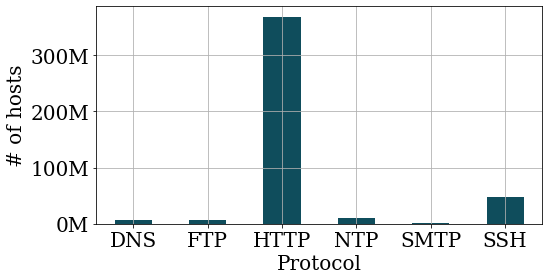

In [49]:
fig, ax = plt.subplots(figsize=(8,4))
best_proto_ct_df.plot.bar(x='best_proto', y='ipint_m', ax=ax, grid=True, color=COLORS[0])
ax.set_ylabel('# of hosts', fontsize=20)
ax.set_xlabel('Protocol', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20, rotation=0)
ax.get_legend().remove()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}M'))
plt.savefig('figs_pam/proto_host_count.png', bbox_inches='tight')
plt.savefig('figs_pam/proto_host_count.pdf', bbox_inches='tight')


In [46]:
best_proto_ct_df['ipint_m'] = best_proto_ct_df['ipint']/1e6

In [13]:
proto_ct_df = proto_ct_all_ddf[proto_ct_all_ddf['best_proto_val']>0].groupby(['best_proto', 'best_proto_val']).count().reset_index().compute()



In [14]:
proto_ct_pivot_df = proto_ct_df.pivot(columns='best_proto', values='ipint', index='best_proto_val')

In [32]:
for c in ['DNS', 'FTP', 'HTTP', 'NTP', 'SMTP','SSH']:
    proto_ct_pivot_df[c+'_m'] = proto_ct_pivot_df[c] / 1e6

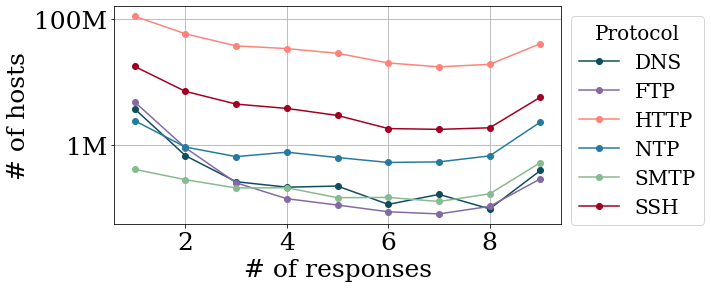

In [42]:
fig, ax = plt.subplots(figsize=(8,4))
proto_ct_pivot_df[['DNS_m', 'FTP_m', 'HTTP_m', 'NTP_m', 'SMTP_m','SSH_m']].plot.line(ax=ax, style='-o', grid=True, color=COLORS)
ax.set_yscale('log')
ax.legend(['DNS', 'FTP', 'HTTP', 'NTP', 'SMTP','SSH'], title='Protocol', ncol=1, fontsize=20, title_fontsize=20, bbox_to_anchor=(1, 1))
ax.set_ylabel('# of hosts', fontsize=25)
ax.set_xlabel('# of responses', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, rotation=0)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}M'))
ax.yaxis.set_minor_formatter(NullFormatter())
#plt.savefig('figs_pam/proto_snapshot_count.png', bbox_inches='tight')
plt.savefig('figs_pam/proto_snapshot_count.pdf', bbox_inches='tight')


## Reindex the Censys hosts  
- For the given survey, we now find those hosts which responded to their calculated best probe and save the new set of hosts

In [48]:
def get_proto_df(ip_proto_ddf, files):
    dfs = []
    if len(files) == 0:
        return
    censys_ddf = dd.read_csv(files, header=None, names=['ip', 'best_proto'])
    censys_ddf['ipint'] = censys_ddf['ip'].apply(ip2int, meta=('ip', str)).astype(int).dropna()
    censys_ddf['best_proto_val'] = 1
    for i in range(10):
        print(i)
        censys_part_ddf = censys_ddf[censys_ddf['ipint']%10==i]
               
        censys_proto_ddf = dd.concat([censys_part_ddf[['ipint', 'best_proto']], ip_proto_ddf[(ip_proto_ddf['ipint']%10==i) &(ip_proto_ddf['best_proto_val']>0)][['ipint', 'best_proto']]])
        censys_proto_filtered_ddf = censys_proto_ddf.groupby('ipint')[['best_proto']].count().reset_index()
        censys_proto_filtered_ddf['best_proto_ct'] = censys_proto_filtered_ddf['best_proto'].apply(lambda x: 1 if x ==2 else 0, meta=('best_proto', int))
        dfs.append(censys_proto_filtered_ddf[['ipint', 'best_proto_ct']])
    return dfs

In [54]:
for s in range(len(survey_dates_map_filtered)-1, -1, -1):
    print(s)
    survey = survey_dates_map_filtered[s]
    snum = s + 83
    print(snum)
    files = get_files(censys_dir + 'snapshot_' + survey['censys'], 'csv')
    print(files[0])
    censys_survey_ddfs = get_proto_df(proto_ct_all_ddf[['ipint', 'best_proto', 'best_proto_val']], files)
    print(snum)
    for i in range(10):
        print(i)
        os.makedirs('/data1/manasvini/censys/proto/best_survey_' + str(snum) + '/part_'+str(i), exist_ok=True)
        censys_survey_ddfs[i] = censys_survey_ddfs[i].rename(columns={'best_proto_ct':'survey_'+ str(snum)})
        censys_survey_ddfs[i].repartition(partition_size='10MB').to_parquet('/data1/manasvini/censys/proto/best_survey_' + str(snum) + '/part_'+str(i), write_index=False,  overwrite=True, compression={"name": "gzip", "values": "lz4"})

8
91
/data1/manasvini/censys/snapshot_20221206/censys-io.research_1w.universal_internet_dataset_part_14.csv
0
1
2
3
4
5
6
7
8
9
91
0
1
2
3
4
5
6
7
8
9
7
90
/data1/manasvini/censys/snapshot_20220906/censys-io.research_1w.universal_internet_dataset_part_103.csv
0
1
2
3
4
5
6
7
8
9
90
0
1
2
3
4
5
6
7
8
9
6
89
/data1/manasvini/censys/snapshot_20220628/censys-io.research_1w.universal_internet_dataset_part_105.csv
0
1
2
3
4
5
6
7
8
9
89
0
1
2
3
4
5
6
7
8
9
5
88
/data1/manasvini/censys/snapshot_20220419/censys-io.research_1m.universal_internet_dataset_part_19.csv
0
1
2
3
4
5
6
7
8
9
88
0
1
2
3
4
5
6
7
8
9
4
87
/data1/manasvini/censys/snapshot_20220125/censys-io.research_1w.universal_internet_dataset_part_17.csv
0
1
2
3
4
5
6
7
8
9
87
0
1
2
3
4
5
6
7
8
9
3
86
/data1/manasvini/censys/snapshot_20210824/censys-io.research_1w.universal_internet_dataset_part_7.csv
0
1
2
3
4
5
6
7
8
9
86
0
1
2
3
4
5
6
7
8
9
2
85
/data1/manasvini/censys/snapshot_20210622/censys-io.research_1w.universal_internet_datas

In [27]:
for s in range(len(survey_dates_map_filtered)):
    survey = survey_dates_map_filtered[s]
    snum = s + 83
    ddfs = []
    for i in range(10):
        print(i, snum)
        files = get_files_no_pfx('/data1/manasvini/censys/proto/best_survey_' + str(snum) + '/part_'+str(i))
        
        ddf = dd.read_parquet(files, block_size='10MB')
        print(ddf.count().compute())
        #ddf = ddf.rename(columns={'survey_' + str(snum):'best_proto_val'})
        ddf['tmp'] = 1
        
        proto_part_ddf = proto_ct_all_ddf[proto_ct_all_ddf['ipint']%10==i]
        proto_part_ddf['tmp'] = 1
        proto_part_ddf['survey_'+str(snum)] = 0
        print(proto_part_ddf.count().compute())
        combined_ddf = dd.concat([proto_part_ddf[['ipint', 'tmp', 'survey_'+str(snum)]]\
                                  , ddf[['ipint', 'tmp', 'survey_'+str(snum)]]])
        print(combined_ddf.columns)
        
        filtered_ddf = combined_ddf.groupby('ipint').sum().reset_index()
        #print(filtered_ddf.count().compute())
        final_ddf = filtered_ddf[filtered_ddf['tmp']==2]
        #ddfs.append(filtered_ddf)
        os.makedirs('/data1/manasvini/censys/proto/best_survey_new_' + str(snum) + '/part_'+str(i), exist_ok=True)
        
        final_ddf[['ipint', 'survey_'+str(snum)]].to_parquet('/data1/manasvini/censys/proto/best_survey_new_' + str(snum) + '/part_'+str(i), write_index=False,  overwrite=True, compression={"name": "gzip", "values": "lz4"})
    

0 83
ipint        45978179
survey_83    45978179
dtype: int64
ipint             44125812
best_proto        44125812
best_proto_val    44125812
tmp               44125812
survey_83         44125812
dtype: int64
Index(['ipint', 'tmp', 'survey_83'], dtype='object')
1 83
ipint        45912585
survey_83    45912585
dtype: int64
ipint             44019381
best_proto        44019381
best_proto_val    44019381
tmp               44019381
survey_83         44019381
dtype: int64
Index(['ipint', 'tmp', 'survey_83'], dtype='object')
2 83
ipint        45982885
survey_83    45982885
dtype: int64
ipint             44131083
best_proto        44131083
best_proto_val    44131083
tmp               44131083
survey_83         44131083
dtype: int64
Index(['ipint', 'tmp', 'survey_83'], dtype='object')
3 83
ipint        45913793
survey_83    45913793
dtype: int64
ipint             44021239
best_proto        44021239
best_proto_val    44021239
tmp               44021239
survey_83         44021239
dtype: int64
I

ipint             44019381
best_proto        44019381
best_proto_val    44019381
tmp               44019381
survey_86         44019381
dtype: int64
Index(['ipint', 'tmp', 'survey_86'], dtype='object')
2 86
ipint        45842886
survey_86    45842886
dtype: int64
ipint             44131083
best_proto        44131083
best_proto_val    44131083
tmp               44131083
survey_86         44131083
dtype: int64
Index(['ipint', 'tmp', 'survey_86'], dtype='object')
3 86
ipint        45778575
survey_86    45778575
dtype: int64
ipint             44021239
best_proto        44021239
best_proto_val    44021239
tmp               44021239
survey_86         44021239
dtype: int64
Index(['ipint', 'tmp', 'survey_86'], dtype='object')
4 86
ipint        45841318
survey_86    45841318
dtype: int64
ipint             44129563
best_proto        44129563
best_proto_val    44129563
tmp               44129563
survey_86         44129563
dtype: int64
Index(['ipint', 'tmp', 'survey_86'], dtype='object')
5 86
ipint

3 89
ipint        45807365
survey_89    45807365
dtype: int64
ipint             44021239
best_proto        44021239
best_proto_val    44021239
tmp               44021239
survey_89         44021239
dtype: int64
Index(['ipint', 'tmp', 'survey_89'], dtype='object')
4 89
ipint        45865658
survey_89    45865658
dtype: int64
ipint             44129563
best_proto        44129563
best_proto_val    44129563
tmp               44129563
survey_89         44129563
dtype: int64
Index(['ipint', 'tmp', 'survey_89'], dtype='object')
5 89
ipint        45809312
survey_89    45809312
dtype: int64
ipint             44022231
best_proto        44022231
best_proto_val    44022231
tmp               44022231
survey_89         44022231
dtype: int64
Index(['ipint', 'tmp', 'survey_89'], dtype='object')
6 89
ipint        45864956
survey_89    45864956
dtype: int64
ipint             44128882
best_proto        44128882
best_proto_val    44128882
tmp               44128882
survey_89         44128882
dtype: int64
I

In [33]:
## Load ANT
dirname = '/data1/manasvini/internet_address_history_it101w-20221101/last10withipint/everalive'

files = list(set(get_files_no_pfx(dirname)))

ant_ddf = dd.read_parquet(files, blocksize='200MB')


In [40]:
for s in range(len(survey_dates_map_filtered)):
    survey = survey_dates_map_filtered[s]
    snum = s + 83
    ddfs = []
    ant_survey_ddf = ant_ddf[['ipint', 'survey_'+str(snum)]]
    for i in range(10):
        print(i, snum)
        files = get_files_no_pfx('/data1/manasvini/censys/proto/best_survey_new_' + str(snum) + '/part_'+str(i))
        
        censys_part_ddf = dd.read_parquet(files, block_size='10MB')
        ant_part_ddf = ant_survey_ddf[ant_survey_ddf['ipint']%10==i]
        ant_part_ddf['ant_survey_'+str(snum)] = ant_survey_ddf['survey_'+str(snum)]
        merged_part_ddf = dd.concat([censys_part_ddf, ant_part_ddf]).fillna(0).groupby('ipint').sum().reset_index()
        merged_part_ddf['combined_survey_'+str(snum)] = merged_part_ddf['survey_'+str(snum)].apply(lambda x: 1 if x ==2 else x, meta=('survey_'+str(snum), int))
        os.makedirs('/data1/manasvini/censys/proto/merged_survey_new_' + str(snum) + '/part_'+str(i), exist_ok=True)
        
        merged_part_ddf[['ipint', 'ant_survey_'+str(snum), 'combined_survey_'+str(snum)]].repartition(partition_size='50MB').to_parquet('/data1/manasvini/censys/proto/merged_survey_new_' + str(snum) + '/part_'+str(i), write_index=False,  overwrite=True, compression={"name": "gzip", "values": "lz4"})

0 83
1 83
2 83
3 83
4 83
5 83
6 83
7 83
8 83
9 83
0 84
1 84
2 84
3 84
4 84
5 84
6 84
7 84
8 84
9 84
0 85
1 85
2 85
3 85
4 85
5 85
6 85
7 85
8 85
9 85
0 86
1 86
2 86
3 86
4 86
5 86
6 86
7 86
8 86
9 86
0 87
1 87
2 87
3 87
4 87
5 87
6 87
7 87
8 87
9 87
0 88
1 88
2 88
3 88
4 88
5 88
6 88
7 88
8 88
9 88
0 89
1 89
2 89
3 89
4 89
5 89
6 89
7 89
8 89
9 89
0 90
1 90
2 90
3 90
4 90
5 90
6 90
7 90
8 90
9 90
0 91
1 91
2 91
3 91
4 91
5 91
6 91
7 91
8 91
9 91
